In [1]:
import sys
sys.path = ['/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/python',
 '/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/python/lib/py4j-0.10.1-src.zip',
 '/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/python',
 '/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/python/lib/py4j-0.10.1-src.zip',
 '/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/python',
 u'/private/var/folders/8j/ptm7g49n12g94wn8cn44frr40000gn/T/spark-6d7026cb-1d7f-487b-a18f-adb8e1bd10fc/userFiles-ebdbc2d0-0c68-4c9a-83c8-54ad356cda18',
 '/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/python/lib/py4j-0.10.1-src.zip',
 '/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/python',
 '/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/python/lib/py4j-0.10.1-src.zip',
 '',
 '/Users/jacobsw/anaconda2/lib/python27.zip',
 '/Users/jacobsw/anaconda2/lib/python2.7',
 '/Users/jacobsw/anaconda2/lib/python2.7/plat-darwin',
 '/Users/jacobsw/anaconda2/lib/python2.7/plat-mac',
 '/Users/jacobsw/anaconda2/lib/python2.7/plat-mac/lib-scriptpackages',
 '/Users/jacobsw/anaconda2/lib/python2.7/lib-tk',
 '/Users/jacobsw/anaconda2/lib/python2.7/lib-old',
 '/Users/jacobsw/anaconda2/lib/python2.7/lib-dynload',
 '/Users/jacobsw/.local/lib/python2.7/site-packages',
 '/Users/jacobsw/.local/lib/python2.7/site-packages/treetagger-1.0.1-py2.7.egg',
 '/Users/jacobsw/anaconda2/lib/python2.7/site-packages',
 '/Users/jacobsw/anaconda2/lib/python2.7/site-packages/Sphinx-1.3.5-py2.7.egg',
 '/Users/jacobsw/anaconda2/lib/python2.7/site-packages/aeosa',
 '/Users/jacobsw/anaconda2/lib/python2.7/site-packages/six-1.10.0-py2.7.egg',
 '/Users/jacobsw/anaconda2/lib/python2.7/site-packages/ojo_ner-0.1-py2.7.egg',
 '/Users/jacobsw/anaconda2/lib/python2.7/site-packages/calysto_scheme-1.1.8-py2.7.egg',
 '/Users/jacobsw/.local/lib/python2.7/site-packages',
 '/Users/jacobsw/.local/lib/python2.7/site-packages/IPython/extensions',
 '/Users/jacobsw/.ipython']

# pyspark-integrated python at: /Users/jacobsw/Desktop/CODER/SPARK/pyspark_path.txt

import os
os.environ["SPARK_HOME"] = "/Users/jacobsw/Desktop/CODER/SPARK/spark-2.0.0-bin-hadoop2.7/"

import pyspark
from pyspark.context import SparkContext

sc = SparkContext() # run once, then you have it until restarting kernel

## I. Pseudo Document

In [2]:
import cPickle
import numpy as np
from nltk.corpus import brown
from spacy.en import English
from spacy.en import STOPWORDS
from collections import defaultdict

In [3]:
norms,norm2prop,norm2propprob,props = cPickle.load(open("/Users/jacobsw/Desktop/UNIV/FALL_2016/LIN389C_RSCH_COMPLING/BAYESIAN/DATA/MCRAE/mcare_norm_data.p",'rb'))

In [4]:
%time
brown_sents = [unicode(' '.join(sent)) for sent in brown.sents()]
parser = English()
parsed_sents = [parser(sent) for sent in brown_sents]

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 5.96 µs


In [5]:
def extract_dep_triples(parsed_sents):   
    triples = []
    for parsed_sent in parsed_sents:
        for token in parsed_sent:
            lemma_triple = (token.lemma_, token.dep_, token.head.lemma_)
            triples.append(lemma_triple)
    return triples

In [6]:
%%time
dep_triples = extract_dep_triples(parsed_sents)

CPU times: user 898 ms, sys: 108 ms, total: 1.01 s
Wall time: 994 ms


In [7]:
%%time
norms_set = set(norms)
norm2vr_f = defaultdict(lambda : defaultdict(list))
for norm,dep,head in dep_triples:
    if norm in norms_set and (dep=='nsubj' or dep=='dobj'):
        vr = head+'-'+dep
        f = np.random.choice(norm2prop[norm],p=norm2propprob[norm])
        norm2vr_f[norm]['vr'].append(vr)
        norm2vr_f[norm]['f'].append(f)

CPU times: user 304 ms, sys: 5.38 ms, total: 309 ms
Wall time: 309 ms


In [8]:
norms, features = norm2vr_f.keys(), props
n2i = {n:i for i,n in enumerate(norms)} # indexing pseudo-docs, each corresponds to 1 norm word.
f2i = {f:i for i,f in enumerate(features)}

In [9]:
words = [] # i.e. v-r pairs.
for norm in norms:
    words += norm2vr_f[norm]['vr']
words = list(set(words))
w2i = {w:i for i,w in enumerate(words)}

In [10]:
word_docs, prop_docs = [], [] # word_docs: for v-r pairs.
for norm in norms:
    word_docs.append(norm2vr_f[norm]['vr'])
    prop_docs.append(norm2vr_f[norm]['f'])

In [11]:
print len(word_docs), len(prop_docs)

327 327


In [12]:
print "Validation for word at idx0: taxi"; print
print word_docs[0]; print
print prop_docs[0]

Validation for word at idx0: taxi

[u'enter-dobj', u'be-nsubj', u'pick-dobj', u'take-nsubj', u'grab-dobj', u'take-dobj', u'call-dobj']

['is_yellow', 'requires_money', 'is_expensive', 'a_car', 'a_car', 'a_car', 'is_expensive']


## II. Bimodal Topic Modeling

** Initialize Topics **

In [13]:
import pandas as pd

In [14]:
from __future__ import division
from operator import add
from collections import Counter

In [15]:
topics = range(100)
W, F, D, T = len(words), len(features), len(word_docs), len(topics)

In [16]:
for word_doc,prop_doc in zip(word_docs,prop_docs):
    for i,(word,prop) in enumerate(zip(word_doc,prop_doc)):
        sampled_topic = np.random.choice(topics)
        word_doc[i] = (word,sampled_topic)
        prop_doc[i] = (prop,sampled_topic)

In [17]:
print "Validation for word at idx0: taxi"; print
print word_docs[0]; print
print prop_docs[0]

Validation for word at idx0: taxi

[(u'enter-dobj', 29), (u'be-nsubj', 5), (u'pick-dobj', 89), (u'take-nsubj', 72), (u'grab-dobj', 21), (u'take-dobj', 29), (u'call-dobj', 26)]

[('is_yellow', 29), ('requires_money', 5), ('is_expensive', 89), ('a_car', 72), ('a_car', 21), ('a_car', 29), ('is_expensive', 26)]


** Visualization Facilities **

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import random

In [19]:
def sample_vis_docs(C_DT): # sample 10 documents, plot distribution over topics the by documents.
    doc_ids = random.sample(range(C_DT.shape[0]),10) # randomly sample 10 docs.
    print "Histogram over Topic by Doc"
    plt.subplots(figsize=(12,4))
    for i,doc_id in enumerate(doc_ids):
        plt.subplot(2,5,i+1)
        plt.tight_layout()
        plt.title("Doc %d" % doc_id)
        plt.ylim((0,10))
        plt.plot(C_DT[doc_id])

In [20]:
def sample_vis_topics(C_WT,C_FT): # sample 10 topics, plot distribution over words/properties by the topics.
    topic_ids = random.sample(range(C_WT.shape[1]),10) # randomly sample 10 docs.
    print "Histogram over %s by Topic" % 'Words'
    plt.subplots(figsize=(12,4))
    for i,topic_id in enumerate(topic_ids):
        plt.subplot(2,5,i+1)
        plt.tight_layout()
        plt.title("Topic %d (Words)" % topic_id)
        plt.ylim((0,10))
        plt.plot(C_WT[:,topic_id])
    plt.show()
    print
    print "Histogram over %s by Topic" % 'Properties'
    plt.subplots(figsize=(12,4))
    for i,topic_id in enumerate(topic_ids):
        plt.subplot(2,5,i+1)
        plt.tight_layout()
        plt.title("Topic %d (Properties)" % topic_id)
        plt.ylim((0,10))
        plt.plot(C_FT[:,topic_id]) 
    plt.show()

** Topic Model **

In [26]:
alpha, beta, gamma = 50/2, .001, .001
alpha_arr = np.array([alpha for _ in range(T)]); Talpha_arr = np.array([alpha*T for _ in range(T)])
beta_arr = np.array([beta for _ in range(T)]); Wbeta_arr = np.array([beta*W for _ in range(T)])
gamma_arr = np.array([gamma for _ in range(T)]); Fgamma_arr = np.array([gamma*F for _ in range(T)])

In [27]:
def get_counts(word_docs,prop_docs):
    C_WT, C_FT, C_DT = np.zeros((W,T)), np.zeros((F,T)), np.zeros((D,T))
    wt_counts = reduce(add,[Counter(word_doc) for word_doc in word_docs])
    ft_counts = reduce(add,[Counter(prop_doc) for prop_doc in prop_docs])
    for (w,t_w),wt_count in wt_counts.iteritems(): C_WT[w2i[w]][t_w] = wt_count 
    for (f,t_f),ft_count in ft_counts.iteritems(): C_FT[f2i[f]][t_f] = ft_count
    for i,doc in enumerate(word_docs): # word,feature pairs have the same topic assignments.
        dt_counts = Counter([t for w,t in doc])
        for j in range(T):
            C_DT[i][j] = dt_counts[j]
    return C_WT, C_FT, C_DT

In [23]:
%%time
C_WT, C_FT, C_DT = get_counts(word_docs, prop_docs)

CPU times: user 661 ms, sys: 14.7 ms, total: 675 ms
Wall time: 666 ms


In [24]:
print C_WT.shape, C_FT.shape, C_DT.shape

(975, 100) (2526, 100) (327, 100)


In [25]:
print "# words: %d | # properties: %d | # documents: %d | # topics: %d" % (W,F,D,T)
print C_WT.sum(), C_FT.sum(), C_DT.sum() # confirmation

# words: 975 | # properties: 2526 | # documents: 327 | # topics: 100
3049.0 3049.0 3049.0


##### Visualization on Initialization: Random Pattern

Histogram over Topic by Doc


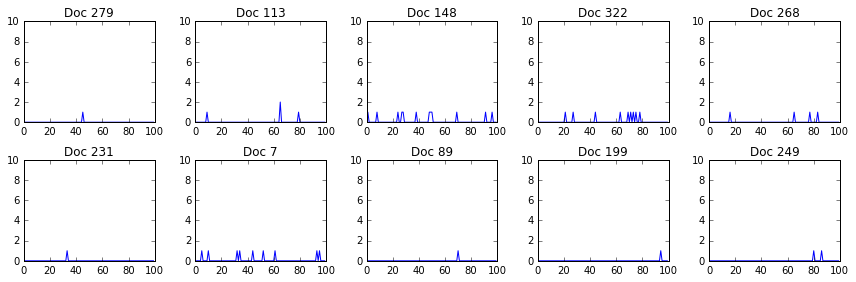

In [26]:
sample_vis_docs(C_DT)

Histogram over Words by Topic


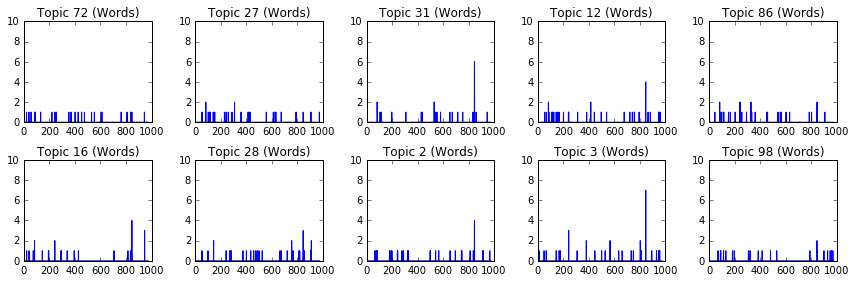


Histogram over Properties by Topic


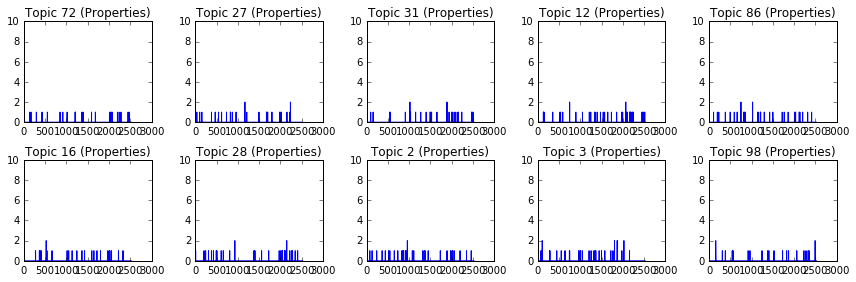

In [27]:
sample_vis_topics(C_WT,C_FT) # What it looks like on random initialization

In [90]:
# old version

# def sample_topic(w_i,f_i,d): # w_i,f_i: indices of word-feature pair at ith pos in d.
#     # compute normalizing constant
#     Z = sum( ((C_WT[w_i][k]+beta) / (sum(C_WT[w][k] for w in xrange(W))+W*beta)) * \
#              ((C_FT[f_i][k]+gamma) / (sum(C_FT[f][k] for f in xrange(F))+F*gamma)) * \
#              ((C_DT[d][k]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) 
#             for k in xrange(T))  
#     # compute numerator (adapted from SG04:8,(3))
#     P = [( ((C_WT[w_i][j]+beta) / (sum(C_WT[w][j] for w in xrange(W))+W*beta)) * \
#            ((C_FT[f_i][j]+gamma) / (sum(C_FT[f][j] for f in xrange(F))+F*gamma)) * \
#            ((C_DT[d][j]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) ) / Z
#           for j in xrange(T)]
#     return np.random.choice(np.array(topics),p=np.array(P))

In [94]:
# revision 1: matrix operations on Z

# def triple_dot(a,b,c):
#     return sum(np.array(a) * np.array(b) * np.array(c))

# def sample_topic(w_i,f_i,d): # w_i,f_i: indices of word-feature pair at ith pos in d.
#     # compute normalizing constant
#     Z_num = triple_dot(C_WT[w_i,:], C_FT[f_i,:], C_DT[d,:]) # NB: need to mult alpha, beta, gamma too!
#     Z_denom = (1/T*C_DT[d,:].sum()) * np.dot(np.apply_along_axis(sum,0,C_WT),
#                                              np.apply_along_axis(sum,0,C_FT))
#     Z = Z_num / Z_denom
#     # compute numerator (adapted from SG04:8,(3))
#     P = [( ((C_WT[w_i][j]+beta) / (sum(C_WT[w][j] for w in xrange(W))+W*beta)) * \
#            ((C_FT[f_i][j]+gamma) / (sum(C_FT[f][j] for f in xrange(F))+F*gamma)) * \
#            ((C_DT[d][j]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) ) / Z
#           for j in xrange(T)]
#     return np.random.choice(np.array(topics),p=np.array(P))

In [95]:
# revision 2: get rid of Z, which is common for all p(z_j | *)

# def normalize(arr):
#     return arr / arr.sum()

# def sample_topic(w_i,f_i,d): # w_i,f_i: indices of word-feature pair at ith pos in d.
    
#     P = np.array([( ((C_WT[w_i][j]+beta) / (sum(C_WT[w][j] for w in xrange(W))+W*beta)) * \
#                     ((C_FT[f_i][j]+gamma) / (sum(C_FT[f][j] for f in xrange(F))+F*gamma)) * \
#                     ((C_DT[d][j]+alpha) / (sum(C_DT[d][t] for t in xrange(T))+T*alpha)) ) 
#                     for j in xrange(T)])
#     return np.random.choice(np.array(topics),p=normalize(P))

In [32]:
# revision 3: revision 1+2, only matrix operations are on P now

def normalize(arr):
    return arr / arr.sum()

def sample_topic(w_i,f_i,d):
    P_num_arr = (C_WT[w_i,:]+beta_arr) * (C_FT[f_i,:]+gamma_arr) * (C_DT[d,:]+alpha_arr)
    P_denom_arr = (np.apply_along_axis(sum,0,C_WT)+Wbeta_arr) * \
                  (np.apply_along_axis(sum,0,C_FT)+Fgamma_arr) * \
                  (T * (C_DT[d,:].sum()+T*alpha))
    P = normalize(P_num_arr / P_denom_arr)
    return np.random.choice(np.array(topics),p=normalize(P))

In [91]:
%timeit sample_topic(0,0,0)

1 loop, best of 3: 271 ms per loop


In [93]:
%timeit sample_topic(0,0,0)

10 loops, best of 3: 158 ms per loop


In [96]:
%timeit sample_topic(0,0,0)

10 loops, best of 3: 130 ms per loop


In [98]:
%timeit sample_topic(0,0,0)

10 loops, best of 3: 31.6 ms per loop


Here we go!

In [28]:
def normalize(arr):
    return arr / arr.sum()

def sample_topic(w_i,f_i,d):
    P_num_arr = (C_WT[w_i,:]+beta_arr) * (C_FT[f_i,:]+gamma_arr) * (C_DT[d,:]+alpha_arr)
    P_denom_arr = (np.apply_along_axis(sum,0,C_WT)+Wbeta_arr) * \
                  (np.apply_along_axis(sum,0,C_FT)+Fgamma_arr) * \
                  (T * (C_DT[d,:].sum()+T*alpha))
    P = normalize(P_num_arr / P_denom_arr)
    return np.random.choice(np.array(topics),p=normalize(P))

In [29]:
def gibbs_test():
    for d,(word_doc,prop_doc) in enumerate(zip(word_docs,prop_docs)):
        for (w,t),(f,_) in zip(word_doc,prop_doc): # a (w,f) pair have the same topic.
            if C_WT[w2i[w]][t]==0 or C_FT[f2i[f]][t]==0 or C_DT[d][t]==0: continue
            C_WT[w2i[w]][t] -= 1
            C_FT[f2i[f]][t] -= 1
            C_DT[d][t] -= 1
            new_t = sample_topic(w2i[w],f2i[f],d)
            C_WT[w2i[w]][new_t] += 1
            C_FT[f2i[f]][new_t] += 1
            C_DT[d][new_t] += 1   

In [30]:
def gibbs(n_iters=30, verbose_freq=1):
    for e in range(n_iters):
        if e!=0 and e%verbose_freq==0: print "@ %dth iteration" % e
        for d,(word_doc,prop_doc) in enumerate(zip(word_docs,prop_docs)):
            for (w,t),(f,_) in zip(word_doc,prop_doc): # a (w,f) pair have the same topic.
                if C_WT[w2i[w]][t]==0 or C_FT[f2i[f]][t]==0 or C_DT[d][t]==0: continue
                C_WT[w2i[w]][t] -= 1
                C_FT[f2i[f]][t] -= 1
                C_DT[d][t] -= 1
                new_t = sample_topic(w2i[w],f2i[f],d)
                C_WT[w2i[w]][new_t] += 1
                C_FT[f2i[f]][new_t] += 1
                C_DT[d][new_t] += 1

In [101]:
%%time
gibbs_test()

CPU times: user 1min 36s, sys: 1.03 s, total: 1min 37s
Wall time: 1min 36s


In [34]:
%%time
gibbs()

@ 1th iteration
@ 2th iteration
@ 3th iteration
@ 4th iteration
@ 5th iteration
@ 6th iteration
@ 7th iteration
@ 8th iteration
@ 9th iteration
@ 10th iteration
@ 11th iteration
@ 12th iteration
@ 13th iteration
@ 14th iteration
@ 15th iteration
@ 16th iteration
@ 17th iteration
@ 18th iteration
@ 19th iteration
@ 20th iteration
@ 21th iteration
@ 22th iteration
@ 23th iteration
@ 24th iteration
@ 25th iteration
@ 26th iteration
@ 27th iteration
@ 28th iteration
@ 29th iteration
CPU times: user 5min 14s, sys: 3.61 s, total: 5min 17s
Wall time: 5min 15s


In [31]:
%%time
gibbs(n_iters=100, verbose_freq=5)

@ 5th iteration
@ 10th iteration
@ 15th iteration
@ 20th iteration
@ 25th iteration
@ 30th iteration
@ 35th iteration
@ 40th iteration
@ 45th iteration
@ 50th iteration
@ 55th iteration
@ 60th iteration
@ 65th iteration
@ 70th iteration
@ 75th iteration
@ 80th iteration
@ 85th iteration
@ 90th iteration
@ 95th iteration
CPU times: user 10min 6s, sys: 6.77 s, total: 10min 12s
Wall time: 10min 7s


## III. Evaluation

##### Property Inference

* $P(f\mid d) = \sum_zP(f\mid z)P(z\mid d)$, where $d$ corresponds to a norm word $n$

In [32]:
def p_f_given_z(f, z): # f, z: prop and topic idx.
    return C_FT[f][z] / C_FT[:,z].sum()

def p_z_given_d(z, d): # z, d: topic and document (norm word) idx.
    return C_DT[d][z] / C_DT[d,:].sum()

def p_f_given_d(f, d):
    return sum(p_f_given_z(f,z)*p_z_given_d(z,d) for z in topics)

In [33]:
def topk_props(norm, verbose=0, k=5):
    d = n2i[norm]
    prop_dist = [p_f_given_d(f,d) for f in xrange(len(features))]
    topk = np.argsort(prop_dist)[::-1][:k]
    if verbose:
        print "Top %d Properties for Word %s" % (k,norm); print
        for i in topk:
            print "#%d Property: %s" % (i+1,features[i])
        return
    return map(lambda i:features[i], topk)

In [34]:
topk_props('cat', verbose=1)

Top 5 Properties for Word cat

#2424 Property: used_for_carpentry
#1509 Property: has_4_legs
#1021 Property: made_of_plastic
#1975 Property: used_by_bouncing
#932 Property: an_animal


In [35]:
topk_props('car', verbose=1)

Top 5 Properties for Word car

#1875 Property: made_of_metal
#961 Property: has_wheels
#749 Property: has_an_engine
#2213 Property: has_4_wheels
#2013 Property: made_of_wood


In [36]:
topk_props('book', verbose=1)

Top 5 Properties for Word book

#597 Property: has_pages
#1875 Property: made_of_metal
#2480 Property: a_building
#2013 Property: made_of_wood
#383 Property: has_a_handle


In [37]:
def evaluate1(): # all correct retrievals in top 5
    accuracies = []
    for i,norm in enumerate(norms):
        if i!=0 and i%50==0: print "... %d words processed" % i
        props_pred = topk_props(norm) # verbose=0, k=5.
        accuracy = sum(.2 if prop in norm2prop[norm] else 0. for prop in props_pred)
        accuracies.append(accuracy)
    print "Average Accuracy on Brown: %.6f%%" % (np.mean(accuracies)*100)

In [38]:
def evaluate2(): # single correct retrieval in top 5
    accuracies = []
    for i,norm in enumerate(norms):
        if i!=0 and i%50==0: print "... %d words processed" % i
        props_pred = topk_props(norm) # verbose=0, k=5.
        accuracy = 1. if any(prop in norm2prop[norm] for prop in props_pred) else 0
        accuracies.append(accuracy)
    print "Average Accuracy on Brown: %.6f%%" % (np.mean(accuracies)*100)

In [52]:
def evaluate3(): # MAP (linear)
    avg_precs = []
    for i,norm in enumerate(norms):
        precs = []
        if i!=0 and i%50==0: print "... %d words processed" % i
        props_pred = (topk_props(norm, k=F)) # F = 2526, i.e. all props
        props_true = norm2prop[norm]
        num_correct = 0
        for i,prop in enumerate(props_pred):
            if prop in props_true:
                num_correct += 1
                precs.append(num_correct / (i+1))
        avg_precs.append(np.mean(precs))
    print "MAP on Brown: %.6f%%" % (np.mean(avg_precs)*100)

In [40]:
%%time
evaluate1()

... 50 words processed
... 100 words processed
... 150 words processed
... 200 words processed
... 250 words processed
... 300 words processed
Average Accuracy on Brown: 18.593272%
CPU times: user 13min 4s, sys: 1.22 s, total: 13min 5s
Wall time: 13min 6s


In [41]:
%%time
evaluate2()

... 50 words processed
... 100 words processed
... 150 words processed
... 200 words processed
... 250 words processed
... 300 words processed
Average Accuracy on Brown: 60.856269%
CPU times: user 13min, sys: 1.5 s, total: 13min 1s
Wall time: 13min 2s


In [53]:
%%time
evaluate3()

... 50 words processed
... 100 words processed
... 150 words processed
... 200 words processed
... 250 words processed
... 300 words processed
MAP on Brown: 10.570393%
CPU times: user 13min 6s, sys: 1.72 s, total: 13min 8s
Wall time: 13min 9s
